# Введение в искусственные нейронные сети
# Урок 4. Сверточные нейронные сети

In [1]:
# Requires the latest pip
#!pip install --upgrade pip

# Current stable release for CPU and GPU
#!pip install tensorflow

# Or try the preview build (unstable)
#!pip install tf-nightly

In [2]:
#!pip install opencv-python

## Практическое задание

Вариант 1. (простой)

- обучить сверточную нейронную сеть в стиле AlexNet (с падением размера ядра свертки и последовательностью блоков свертка-пулинг  (conv-pool)-(conv-pool)-...) на датасете fashion-mnist или cifar10
- оценить рост точности при увеличении ширины сети (больше ядер)
- оценить рост точности при увеличении глубины сети (больше слоев)
- (опциционально)сравнить с точностью полносвязной сети для этой выборки
    </li>

Вариант 2. (сложный)
- реализовать нейронную сеть или стек из сверток (Concatenate) на сifar10.
- оценить рост точности при увеличении ширины сети (больше ядер), больше нитей.
- оценить рост точности при увеличении глубины сети (больше слоев)
    </li>
</ol>

In [3]:
from __future__ import print_function
import tensorflow.keras as keras 
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Input, Dense, Dropout, Activation, Flatten, Concatenate
from tensorflow.keras.layers import Conv2D, MaxPooling2D #, AveragePooling2D, GlobalAveragePooling2D 
from tensorflow.keras.utils import plot_model, to_categorical
import matplotlib.pyplot as plt
import numpy as np
import os

In [4]:
classes=['самолет', 'автомобиль', 'птица', 'кот', 'олень', 'собака', 'лягушка', 'лошадь', 'корабль', 'грузовик']
# установка параметров нейросети
batch_size = 32
num_classes = 10
epochs = 5
data_augmentation = False
num_predictions = 20
save_dir = os.path.join(os.getcwd(), 'saved_models')
model_name = 'keras_cifar10_trained_model.h5'

# разделение тренировочной и тестовой выборки
(x_train, y_train), (x_test, y_test) = cifar10.load_data()
print('x shape:', x_train.shape)
print(x_train.shape[0], 'тренировочные примеры')
print(x_test.shape[0], 'тестовые примеры')

# преобразование матрицы чисел 0-9 в бинарную матрицу чисел 0-1
y_train = to_categorical(y_train, num_classes)
y_test = to_categorical(y_test, num_classes)


x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255

x_val = x_train[40000:]
y_val = y_train[40000:]
x_train = x_train[:40000]
y_train = y_train[:40000]

print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'тренировочные примеры')
print(x_val.shape[0], 'валидационные примеры')
data_augmentation = False

x shape: (50000, 32, 32, 3)
50000 тренировочные примеры
10000 тестовые примеры
x_train shape: (40000, 32, 32, 3)
40000 тренировочные примеры
10000 валидационные примеры


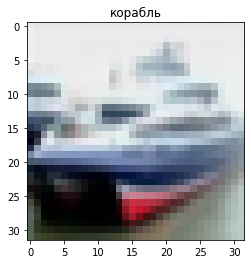

In [5]:
N = 1

plt.imshow(x_test[N][:,:,:])
plt.title(classes[np.argmax(y_test[N,:])])
plt.show()

In [6]:
# конфигурирование групп слоев нейросети
# слои нейросети отвественные за свертку и max-pooling

first_input = Input(shape=(32,32,3))
x11= Conv2D(16,(3,3),activation='relu',padding = 'same')(first_input)
x12= Conv2D(16,(3,3),activation='relu')(x11)
x13= Conv2D(16,(3,3),activation='relu')(x12)
x14= Conv2D(16,(3,3),activation='relu')(x13)
x15 = MaxPooling2D(pool_size=(3, 3))(x14)
x16 = Flatten()(x15)

#second_input = Input(shape=(32,32,3))
x21= Conv2D(4,(3,3),activation='relu',padding = 'same')(first_input)
x22= Conv2D(8,(3,3),activation='relu',padding = 'same')(x21)
x23= Conv2D(16,(3,3),activation='relu',padding = 'same')(x22)
x24= Conv2D(32,(3,3),activation='relu',padding = 'same')(x23)
x25= Flatten()(x24)

#third_input = Input(shape=(32,32,3))
x31= Conv2D(32,(4,4),activation='relu')(first_input)
x32= Conv2D(64,(4,4),activation='relu')(x31)
x33 = MaxPooling2D(pool_size=(3, 3))(x32)
x34= Conv2D(128,(4,4),activation='relu')(x33)
x35 = MaxPooling2D(pool_size=(3, 3))(x34)
x36= Flatten()(x35)

# конфигурирование/слияние слоев нейросети
merge_one = Concatenate(  axis =-1 )([x16, x25])
merge_two_1 = Concatenate(axis = -1)([merge_one, x36])
merge_two = Dense(512, activation='tanh')(merge_two_1)
merge_two = Dense(128, activation='tanh')(merge_two)
merge_two = Dense(10, activation='softmax')(merge_two)

model_stek = Model(inputs=first_input, outputs=merge_two)

# инициализация RMSprop optimizer
#opt = tensorflow.keras.optimizers.RMSprop(lr=0.0001, decay=1e-6)
ada_grad = keras.optimizers.Adagrad(learning_rate=0.1, epsilon=1e-08, decay=0.0)
# компиляция модели
model_stek.compile(optimizer=ada_grad, loss=keras.losses.CategoricalCrossentropy(),
              metrics=['accuracy'])
"""model_stek.compile(loss='categorical_crossentropy',
              optimizer='SGD',
              metrics=['accuracy'])"""

if not data_augmentation:
    print('Не используется data augmentation')
    model_stek.fit(x_train, y_train,
                   batch_size=batch_size,
                   epochs=epochs,
                   validation_data=(x_val, y_val),
                   shuffle=True)
else:
    print('Использование data augmentation в реальном времени')
    # Препроцессинг и data augmentation в реальном времени:
    datagen = ImageDataGenerator(
        featurewise_center=False,
        samplewise_center=False,
        featurewise_std_normalization=False,
        samplewise_std_normalization=False,
        zca_whitening=False, 
        zca_epsilon=1e-06, 
        rotation_range=5, 
        width_shift_range=0.1,
        height_shift_range=0.1,
        shear_range=0., 
        zoom_range=0., 
        channel_shift_range=0.,
        fill_mode='nearest',
        cval=0.,
        horizontal_flip=True,
        vertical_flip=False,
        rescale=None,
        preprocessing_function=None,
        data_format=None,
        validation_split=0.05)

    # запуск data augmentation через fit
    #datagen.fit(x_train)

    # запуск data augmentation через fit_generator
    model_stek.fit_generator(datagen.flow(x_train, y_train,
                                          batch_size=batch_size),
                             epochs=epochs,
                             validation_data=(x_val, y_val),
                             workers=-1)

# сохранение модели и весов
"""if not os.path.isdir(save_dir):
    os.makedirs(save_dir)
model_path = os.path.join(save_dir, model_name)
model_stek.save(model_path)
print('сохранить обученную модель как %s ' % model_path)"""

2022-03-24 17:45:54.973011: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Не используется data augmentation


2022-03-24 17:45:56.592979: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)


Epoch 1/5
1250/1250 [==============================] - 532s 424ms/step - loss: 2.1082 - accuracy: 0.2259 - val_loss: 1.4537 - val_accuracy: 0.4811
Epoch 2/5
1250/1250 [==============================] - 531s 424ms/step - loss: 1.3477 - accuracy: 0.5185 - val_loss: 1.2045 - val_accuracy: 0.5750
Epoch 3/5
1250/1250 [==============================] - 491s 393ms/step - loss: 1.0974 - accuracy: 0.6142 - val_loss: 1.1330 - val_accuracy: 0.6014
Epoch 4/5
1250/1250 [==============================] - 489s 391ms/step - loss: 0.9581 - accuracy: 0.6646 - val_loss: 1.0366 - val_accuracy: 0.6354
Epoch 5/5
1250/1250 [==============================] - 497s 398ms/step - loss: 0.8722 - accuracy: 0.6939 - val_loss: 1.0573 - val_accuracy: 0.6339


"if not os.path.isdir(save_dir):\n    os.makedirs(save_dir)\nmodel_path = os.path.join(save_dir, model_name)\nmodel_stek.save(model_path)\nprint('сохранить обученную модель как %s ' % model_path)"

# Accuracy на тестовой выборке(обучение велось по выборке в 40000 из x_train, валидация по оставшимся 10000)

In [7]:
# проверка работы обученной модели
scores = model_stek.evaluate(x_test, y_test, verbose=1)
print('Test loss:', scores[0])
print('Test accuracy:', scores[1])

313/313 [==============================] - 25s 79ms/step - loss: 1.0521 - accuracy: 0.6344
Test loss: 1.052139163017273
Test accuracy: 0.6344000101089478


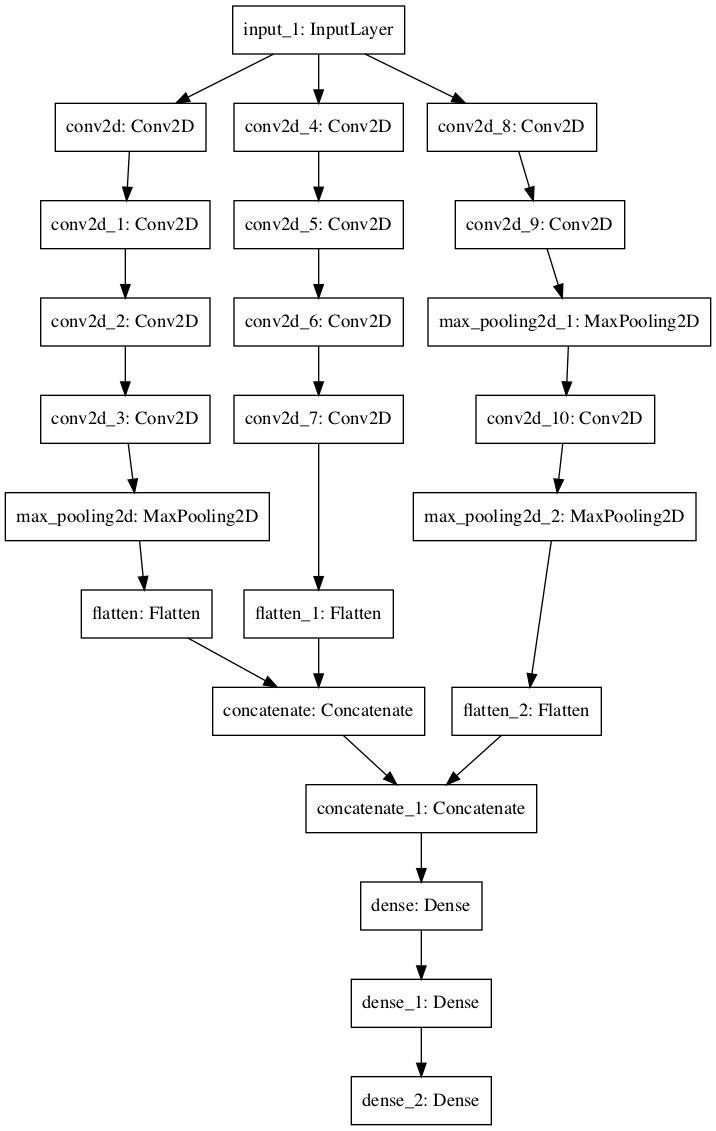

In [8]:
plot_model(model_stek)

In [9]:
model_stek.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 32, 32, 16)   448         input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 30, 30, 16)   2320        conv2d[0][0]                     
__________________________________________________________________________________________________
conv2d_4 (Conv2D)               (None, 32, 32, 4)    112         input_1[0][0]                    
______________________________________________________________________________________________

## Дополнительные материалы

<ol>
    <li>https://keras.io/layers/convolutional/</li>
    <li>https://keras.io/layers/pooling/</li>
    <li>https://keras.io/preprocessing/image/</li>
</ol>

## Используемая литература 

Для подготовки данного методического пособия были использованы следующие ресурсы:
<ol>
    <li>https://keras.io</li>
    <li>Шакла Н. — Машинное обучение и TensorFlow 2019</li>
    <li>Николенко Сергей Игоревич, Кадурин А. А. - Глубокое обучение. Погружение в мир нейронных сетей  2018</li>
    <li>Francois Chollet - Deep Learning with Python 2018</li>
    <li>Alex Krizhevsky, Ilya Sutskever, Geoffrey E. Hinton - ImageNet Classification with Deep Convolutional Neural Networks</li>
    <li>Karen Simonyan, Andrew Zisserman - Very Deep Convolutional Networks for Large-Scale Image Recognition</li>
    <li>Википедия</li>    
</ol>